In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
from transformers import BertTokenizerFast, BertTokenizer
from transformers import BertTokenizer, BertModel
import torch
import pdb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

%cd /content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC
RGC_Dataset = pd.read_csv('outputO.txt')

RGC_Dataset['image'] = RGC_Dataset['image'].apply(
    #lambda x: f'/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/roco_new/images/{x}')
    lambda x: f'{x}')
RGC_Dataset.head()


/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC


,image,caption
0,synpic38562.jpg,Non enhancing mass in Third Ventricle Hydro...
1,synpic38633.jpg,There is smooth symmetric and homogeneous thic...
2,synpic38559.jpg,Non enhancing mass in Third Ventricle Hydro...
3,synpic38581.jpg,Enlarged dysmorphic left cerebral hemisphere. ...
4,synpic38533.jpg,Superior uterine segment Seperate uterine hor...


In [ ]:
def text_preprocessing(text): #text preprocesing
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [ ]:
RGC_Dataset['caption'] = RGC_Dataset['caption'].apply(text_preprocessing)
RGC_Dataset.head()


,image,caption
0,synpic38562.jpg,[start] non enhancing mass in third ventricle ...
1,synpic38633.jpg,[start] there is smooth symmetric and homogene...
2,synpic38559.jpg,[start] non enhancing mass in third ventricle ...
3,synpic38581.jpg,[start] enlarged dysmorphic left cerebral hemi...
4,synpic38533.jpg,[start] superior uterine segment seperate uter...


In [ ]:
MAX_LENGTH = 50
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)


vocab = tokenizer.get_vocabulary()


tokenizer.adapt(RGC_Dataset['caption'])
vocab = tokenizer.get_vocabulary()
print('vocab ',vocab)


print(tokenizer.get_vocabulary())


vocab  ['', '[UNK]', 'the', '[start]', '[end]', 'of', 'and', 'with', 'in', 'mass', 'right', 'left', 'is', 'a', 'to', 'ct', 'no', 'on', 'there', 'lesion', 'contrast', 'lobe', 'demonstrates', 'axial', 'enhancement', 'lateral', 'large', 'enhancing', 'into', 'from', 'within', 'are', 'frontal', 'image', 'images', 'multiple', 'posterior', 'at', 'or', 'edema', 'signal', 'small', 'bone', 'demonstrate', 'sinus', 'cystic', 'an', 'seen', 'bilateral', 'both', 'artery', 'shows', 'normal', 'tissue', 'anterior', 'temporal', 'soft', 'chest', 'fracture', 'through', 'consistent', 'as', 'associated', 'which', 'fluid', 'extending', 'distal', 'this', 'brain', 'lower', 'lesions', 'wall', 'thickening', 'vein', 'upper', 'involving', 'mri', 'present', 'surrounding', 'fat', 'density', 'cerebral', 'pulmonary', 'noted', 'note', 'matter', 'proximal', 'ventricle', 'superior', 'well', 'parietal', 'following', 'lung', 'enlarged', 'medial', 'view', 'diffusion', 'air', 'demonstrating', 'evidence', 'fossa', 'radiograph'

In [ ]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",  # add medical tokens to enhance the model
    vocabulary=tokenizer.get_vocabulary())



idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)



In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(RGC_Dataset['image'], RGC_Dataset['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)


slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])


test_imgs = []
test_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    test_imgs.extend([imgv] * capv_len)
    test_captions.extend(img_to_cap_vector[imgv])

print(len(train_captions))
print(len(test_captions))

14747
3687


In [ ]:
len(train_imgs), len(train_captions), len(test_imgs), len(test_captions)

(14747, 14747, 3687, 3687)

In [ ]:
def load_RGCdata(img_path, caption):
    print('type caption ',type(caption))
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img,channels=3)
    print('img', img)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [ ]:

%cd /content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))


train_dataset = train_dataset.map(
    load_RGCdata, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(type(train_dataset))


test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_imgs, test_captions))

test_dataset = test_dataset.map(
    load_RGCdata, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images
type caption  <class 'tensorflow.python.framework.ops.SymbolicTensor'>
img Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
type caption  <class 'tensorflow.python.framework.ops.SymbolicTensor'>
img Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)


In [ ]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
       # tf.keras.layers.RandomZoom(0.2),#new
        #tf.keras.layers.RandomTranslation(0.2, 0.2),#new
       # tf.keras.layers.RandomHeight(0.2),#new
        #tf.keras.layers.RandomWidth(0.2),#new

    ]
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class GaussianSmoothingAugmentation(Layer):
    def __init__(self, kernel_size=3, sigma=1.0, **kwargs):
        self.kernel_size = kernel_size
        self.sigma = sigma
        super(GaussianSmoothingAugmentation, self).__init__(**kwargs)

    def build(self, input_shape):
        kernel = self.gaussian_kernel(self.kernel_size, self.sigma)
        self.kernel = K.constant(kernel, dtype=tf.float32)
        self.kernel = self.kernel[:, :, None, None]

    def gaussian_kernel(self, size, sigma):
        x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        x = tf.exp(-0.5 * (x / sigma) ** 2)
        kernel = x[:, None] * x[None, :]
        kernel /= tf.reduce_sum(kernel)
        return kernel

    def call(self, inputs, training=None):
        if training:
            outputs = tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
            return outputs
        else:
            return inputs

    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
from keras.applications import InceptionV3, DenseNet121, ResNet50,EfficientNetB0
#from tensorflow.keras.applications import InceptionV3, DenseNet121, ResNet50
from keras.models import Model ,Sequential
from keras.layers import Dense,GlobalAveragePooling2D ,GlobalMaxPooling2D,Dropout, GRU,LSTM,Embedding, BatchNormalization, Conv2D, LSTM, Flatten, concatenate
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import tensorflow as tf
from keras.applications import vgg16
from keras.preprocessing.sequence import pad_sequences


tf.config.run_functions_eagerly(True)

def CNN_Encoder():

    %cd /content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/.ipynb_checkpoints/swin-rgc-roco-medicat


    img_rows, img_cols=299, 299


    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False, #true
        weights='imagenet',
        input_shape=(img_rows, img_cols, 3)
    )
    efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) #best result
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    vgg16_model =vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(299,299,3))

    for layer in inception_v3.layers:
      layer.trainable=False
    for layer in densenet.layers:
      layer.trainable=False
    for layer in resnet50.layers:
      layer.trainable=False
    for layer in vgg16_model.layers:
      layer.trainable=False
    for layer in efficientnet_model.layers:
      layer.trainable=False


    output=efficientnet_model.output
    print('PRINT OUTPUT SHAPE ',output.shape)



    top_model=GlobalAveragePooling2D()(output)
    #top_model=GlobalMaxPooling2D()(output)

    top_model=Dense(1024, activation='relu')(top_model)
    top_model=Dense(512, activation='relu')(top_model)
    #top_model=LSTM(128, return_sequences=True)(top_model)
    GaussianSmoothingAugmentation(kernel_size=3, sigma=1.0, input_shape=(28, 28, 1))

    #top_model=GlobalAveragePooling2D()(top_model)
    #top_model = Conv2D(128, (7, 7), padding='same', activation='relu', strides=(2, 2))(top_model)

    #top_model = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
    top_model = tf.keras.layers.Reshape((-1, top_model.shape[-1]))(top_model)
    top_model = GRU(128, return_sequences=False)(top_model)
    top_model = tf.keras.layers.Reshape((-1, top_model.shape[-1]))(top_model)
    top_model=Dense(2048, activation='relu')(top_model)
    top_model=Dropout(0.2)(top_model)
    print('top_model.shape',top_model.shape)


    #print('output', output.shape)
    top_model = tf.keras.layers.Reshape(
        (-1, top_model.shape[-1]))(top_model)


    cnn_model = tf.keras.models.Model(efficientnet_model.input, top_model)


    print(cnn_model.summary())
    return cnn_model

In [ ]:
!pip install tensorflow matplotlib pydot

In [ ]:
class MedicalTransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")

    def call(self, x, training):

        x = self.layer_norm_1(x)
        x = self.dense(x)


        attn_output = self.attention(      #self attension
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output) # This line implements a residual connection.
        #The output from the self-attention layer (attn_output) is added back to the original input (x) before being passed through another
        # layer normalization step (self.layer_norm_2).
        # Residual connections help address the vanishing/exploding gradient problem in deep neural networks.

        return x

In [ ]:
class EmbeddingsLayer(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)


        return token_embeddings + position_embeddings

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images
EmbeddingsLayer(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape
#converts caption text from the training dataset into numerical embeddings

/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images


TensorShape([32, 50, 512])

In [ ]:
#from transformers import BertTokenizerFast, BertTokenizer
#%cd /content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/bert-base-uncased
# ORIGINAL
class MedicalTransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()


        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)


        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)
        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)


        ffn_out = self.ffn_layer_1(out_2)

        ffn_out = self.dropout_1(ffn_out, training=training)

        ffn_out = self.ffn_layer_2(ffn_out)


        ffn_out = self.layernorm_3(ffn_out + out_2)

        ffn_out = self.dropout_2(ffn_out, training=training)


        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)


In [ ]:
def process_tensor_to_string(self, tensor):
    # Convert the tensor to a numpy array
    tensor_np = tensor.numpy()
    # Ensure it's a string if it's not already
    #if tensor_np.dtype != 'str':
    tensor_np = tensor_np.astype(str)
    return tensor_np

In [ ]:
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

from nltk.translate.meteor_score import meteor_score
from nltk.translate import meteor
from nltk import word_tokenize
import numpy as np
import math


class MedicalImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()

        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
        self.per_tracker = tf.keras.metrics.Mean(name="precision")
        #self.rec_tracker = tf.keras.metrics.Mean(name="recall")

    def calculate_loss(self, y_true, y_pred, mask):

        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask

        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_precision(self,y_true, y_pred, mask):
      y_pred = tf.argmax(y_pred, axis=-1)
      y_true = tf.cast(y_true, dtype=tf.int64)
      mask = tf.cast(mask, dtype=tf.float32)

      true_positives = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32) * mask)

      predicted_positives = tf.reduce_mean(mask)


      precision = true_positives / (true_positives + predicted_positives)
      return precision

    def calculate_recall(self,y_true, y_pred, mask=None):
      y_true = tf.cast(y_true, dtype=tf.float32)
      y_pred = tf.cast(y_pred, dtype=tf.float32)

      if mask is not None:
            mask = tf.cast(mask, dtype=tf.float32)
            if mask.shape != y_true.shape:
              mask = tf.broadcast_to(mask, y_true.shape)
            y_true = y_true * mask
            y_pred = y_pred * mask

      true_positives = tf.round(tf.clip_by_value(y_true * y_pred, 0, 1))
      possible_positives = tf.round(tf.clip_by_value(y_true, 0, 1))
      recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
      return recall


 # it identifies the most likely word predicted by the model for each position in the captions across the vocabulary.
    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))#this creates a binary tensor where 1 indicates a correct prediction and 0 indicates an incorrect prediction.
        accuracy = tf.math.logical_and(mask, accuracy)#this removes incorrect predictions caused by padding elements.
        accuracy = tf.cast(accuracy, dtype=tf.float32)

        mask = tf.cast(mask, dtype=tf.float32)
        acc = tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)



    def compute_loss_and_acc(self, img_embed, captions, training=True):
      encoder_output = self.encoder(img_embed, training=True)
      y_input = captions[:, :-1] #prefix of captions
      y_true = captions[:, 1:] #true captions


      mask = (y_true != 0)
      y_pred = self.decoder(y_input, encoder_output, training=True, mask=mask)

      loss = self.calculate_loss(y_true, y_pred, mask)
      acc = self.calculate_accuracy(y_true, y_pred, mask)
      per=self.calculate_precision(y_true, y_pred, mask)
      #rec=self.calculate_recall(y_true, y_pred, mask)


      return loss, acc, per#, rec#, f1_score, specificity


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
          imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)


        with tf.GradientTape() as tape:
            loss, acc, per = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        self.per_tracker.update_state(per)
        #self.rec_tracker.update_state(rec)


        return {"loss": self.loss_tracker.result(),
                "accuracy": self.acc_tracker.result(),
                "precision": self.per_tracker.result()}
                #"recall": self.rec_tracker.result()}

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc, per = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        self.per_tracker.update_state(per)
        #self.rec_tracker.update_state(rec)
        #self.blue_tracker.update_state(bl)

        return {"loss": self.loss_tracker.result(),
                "accuracy": self.acc_tracker.result(),
                "precision": self.per_tracker.result()}
                #"recall": self.rec_tracker.result()}


    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker, self.per_tracker ]#,self.rec_tracker]

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', repo_type='tf-hub')
encoder = MedicalTransformerEncoderLayer(EMBEDDING_DIM, 8)
decoder = MedicalTransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
Medicalcaption_model = MedicalImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

#cnn_mode.summary()

/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/.ipynb_checkpoints/swin-rgc-roco-medicat
PRINT OUTPUT SHAPE  (None, 10, 10, 1280)
top_model.shape (None, 1, 2048)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 299, 299, 3)          0         ['input_7[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 299, 299, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
  

In [ ]:
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none" #change
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
EPOCHS=65
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15

#lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)
lr_schedule = LRSchedule(post_warmup_learning_rate=0.001, warmup_steps=1000)

Medicalcaption_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=cross_entropy,
    metrics=['accuracy']
)


/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images
history_list = []
#for learning_rate in learning_rates:

history = Medicalcaption_model.fit(train_dataset,epochs=5,validation_data=test_dataset)
                            #,callbacks=[early_stopping])
#history_list.append(history.history)

#history_list.append(history.history)

print(history.on_predict_batch_begin)
print(history.on_predict_begin)


/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images
Epoch 1/5
461/461 [==============================] - 3001s 6s/step - loss: 6.0767 - accuracy: 0.1506 - precision: 0.1266 - val_loss: 4.5653 - val_accuracy: 0.2741 - val_precision: 0.2149
Epoch 2/5
461/461 [==============================] - 304s 650ms/step - loss: 3.8929 - accuracy: 0.3326 - precision: 0.2488 - val_loss: 3.5381 - val_accuracy: 0.3769 - val_precision: 0.2734
Epoch 3/5
461/461 [==============================] - 305s 651ms/step - loss: 3.0669 - accuracy: 0.4313 - precision: 0.3006 - val_loss: 3.0951 - val_accuracy: 0.4545 - val_precision: 0.3119
Epoch 4/5
461/461 [==============================] - 300s 642ms/step - loss: 2.4902 - accuracy: 0.5143 - precision: 0.3390 - val_loss: 2.8190 - val_accuracy: 0.5054 - val_precision: 0.3349
Epoch 5/5
461/461 [==============================] - 299s 636ms/step - loss: 2.1068 - accuracy: 0.5726 - precision: 0.3637 - val_loss: 2.6814 - val_accu

In [ ]:
#!pip install matplotlib tensorflow

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])


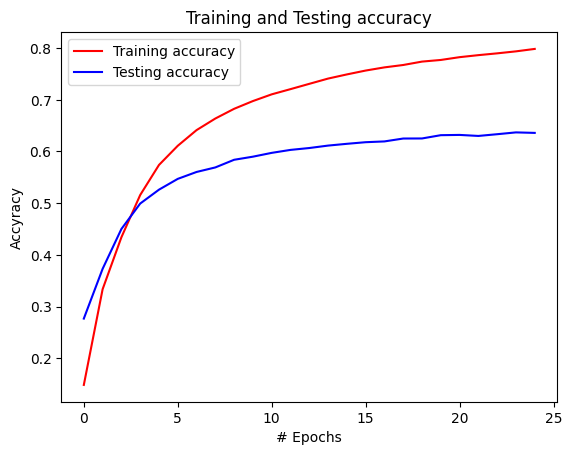

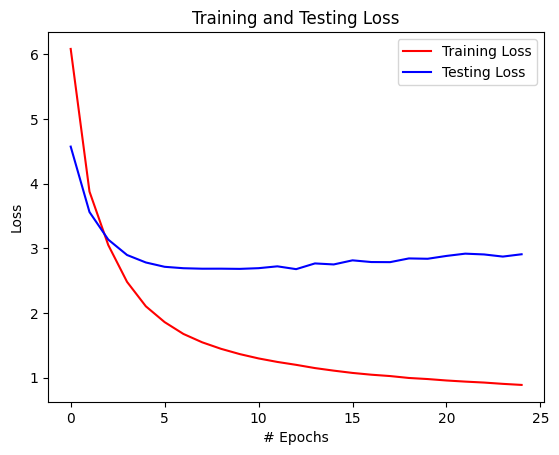

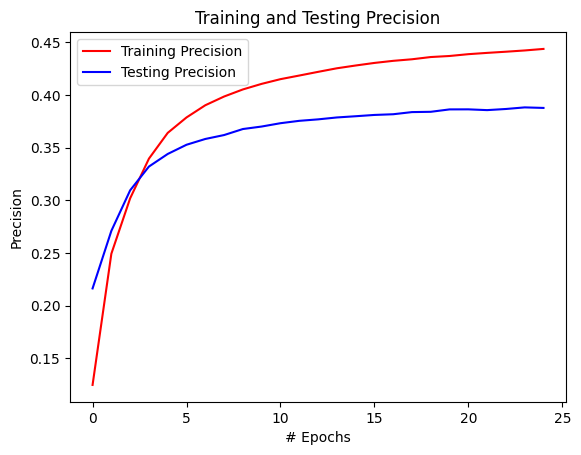

In [ ]:
import matplotlib.pyplot as plt
import math

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

perc = history.history.get('precision')
val_precision=history.history.get('val_precision')

#print('val_precision',val_precision)

epochs = range(len(acc))

#epochs=1
fig1 = plt.figure()  # Create the first figure
plt.figure(fig1.number)
plt.plot(epochs, acc, 'r',label='Training accuracy')
plt.plot(epochs, val_acc, 'b',label='Testing accuracy')
plt.title('Training and Testing accuracy')

plt.xlabel("# Epochs")
plt.ylabel("Accyracy")
plt.legend(loc=0)

fig2 = plt.figure()
plt.figure(fig2.number)

plt.plot(epochs, loss, 'r',label='Training Loss')
plt.plot(epochs, val_loss, 'b',label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)

fig3 = plt.figure()  # Create the first figure
plt.figure(fig3.number)


plt.plot(epochs, perc, 'r',label='Training Precision')
plt.plot(epochs, val_precision, 'b',label='Testing Precision')
plt.title('Training and Testing Precision')
plt.xlabel("# Epochs")
plt.ylabel("Precision")
plt.legend(loc=0)


plt.figure(fig1.number)
plt.figure(fig2.number)
plt.figure(fig3.number)
plt.show()


In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
import numpy as np


def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    return img


def generate_caption(img_path):

    #tf.random.set_seed(None)
    #np.random.seed(None)
    # Assuming load_image_from_path function loads and preprocesses the image
    img = load_image_from_path(img_path)  # You need to define load_image_from_path(img_path) function
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)


    img_encoded = caption_model.encoder(img_embed, training=True)
    #print('ENCODEeeeeee ', img_encoded)


    y_inp = '[start]'

    for i in range(MAX_LENGTH-1):

        tokenized = tokenizer([y_inp])[:, :-1]

        mask = tf.cast(tokenized != 0, tf.int32)

        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])


        pred_word = idx2word(pred_idx).numpy().decode('utf-8')


        # Generate predictions for the next word
        pred = caption_model.decoder(tokenized, img_encoded, training=False, mask=mask)
        pred_idx = np.argmax(pred[0, i, :])

        pred_word = idx2word(pred_idx).numpy().decode('utf-8')


        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    # Remove the '[start]' token from the beginning of the caption
    y_inp = y_inp.replace('[start] ', '')

    return y_inp



y_true::  [start] a cortical avulsion is present at the proximal lateral tibia [end]
detected caption ::
axial ct image of the abdomen at the level of the gallbladder demonstrates a nodular appearance to the liver splenomegaly and dilated splenorenal variceal veins one segment demonstrates calcified walls incidentally there are calcifiend gallstones noted
y_true::  [start] two enhancing foci in the brain stem one within right side of mid brain and the second within the pons minimal focal enlargement of pons no evidence of prior hemorrhage [end]
detected caption ::
axial ct image of the abdomen at the level of the gallbladder demonstrates a nodular appearance to the liver splenomegaly and dilated splenorenal variceal veins one segment demonstrates calcified walls incidentally there are calcifiend gallstones noted
y_true::  [start] enhancing mass in the pineal region causing third and lateral ventricular hydrocephalus [end]
detected caption ::
axial ct image of the abdomen at the level o

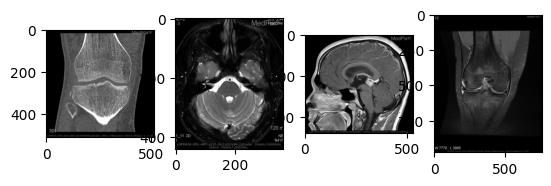

In [ ]:
# Plot the images on a subplots array
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4)
# Loop through subplots and draw image
#img_path = '/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images/' + 'synpic28402.jpg'
for ii in range(4):
  #val_list = list(val_dataset)
  #random_row = val_list.pop(np.random.randint(len(val_list)))
  #print('random_row',random_row)
  #y_true= random_row['caption']
  y_true=val_captions[ii]
  print('y_true:: ', y_true)
  img_path = '/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images/' + val_imgs[ii]
  #print('y_true:: ', y_true)
  #img_path = '/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images/' + random_row['image']
  #print(random_row['image'])
  pred_caption = generate_caption(img_path)
  print('detected caption ::')
  print(pred_caption)
  img = plt.imread(img_path)
  axes[ii].imshow(img)
  axes[ii].axis('on')  # Hide the axis
  #axes[ii].set_title(pred_caption)
# Render the figure
plt.show()


y_true::  ,Axial CT image through the mid-thoracic region demonstrates 
 no evidence of pulmonary embolism or thoracic aortic pathology. 
  In the upper outer quadrant of the left breast is a dense angular mass.
random_image synpic28473.jpg

detected caption ::
axial ct image of the abdomen at the level of the gallbladder demonstrates a nodular appearance
 to the liver splenomegaly and dilated splenorenal variceal veins one segment demonstrates calcif


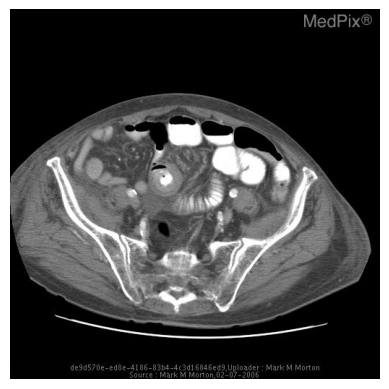

In [ ]:
import random
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
#from sacremoses import corpus
#from rouge import Rouge


#random_row = captions.sample(1).iloc[0]
#y_true= random_row['caption']
y_true= ",Axial CT image through the mid-thoracic region demonstrates \n no evidence of pulmonary embolism or thoracic aortic pathology. \n  In the upper outer quadrant of the left breast is a dense angular mass."
print('y_true:: ', y_true)
#print('random_image',random_row['image'])
print('random_image','synpic28473.jpg')
#print('random_caption: ',random_row['caption'])

#img_path = '/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images/' + random_row['image']
img_path = '/content/drive/MyDrive/Colab_Notebooks/Medical-Vision-Langauge-Transformer/dataset/RGC/images/' + 'synpic28402.jpg'
#print(img_path)
pred_caption = generate_caption(img_path)
print()
print('detected caption ::')
#print(pred_caption)
print(pred_caption[:95] + "\n" + pred_caption[95:192])
img=Image.open(img_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


#print(pred_caption[:100] + "\n" + pred_caption[100:])

#-----------------------------------------
# (val_imgs, val_captions))



#rouge_scorer = Rouge()
#rouge_scores = {}
#for metric in ["rouge_l", "rouge_1", "rouge_2"]:
#  scores = rouge_scorer.get_scores(y_true, pred_caption)[metric]
#  rouge_scores[metric] = {"p": scores.p, "r": scores.r, "f": scores.f}

#print(rouge_scores)



In [ ]:
def precision_recall_specificity(true_caption, predicted_caption):
    # Convert captions to sets of words
    true_words = set(true_caption.split())
    predicted_words = set(predicted_caption.split())

    # True Positives (TP): words in both true_caption and predicted_caption
    tp = len(true_words & predicted_words)

    # TN is the words in the vocabulary that are not in either true_words or predicted_words
    tn = len(vocab - true_words - predicted_words)

    # False Positives (FP): words in predicted_caption but not in true_caption
    fp = len(predicted_words - true_words)

    # False Negatives (FN): words in true_caption but not in predicted_caption
    fn = len(true_words - predicted_words)

    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    Accuracy = (tp+tn) / (tp + tn + fn + fp)


    return precision, recall, Accuracy




predicted_captions = [generate_caption(img) for img in val_imgs]
total_precision = 0.0
total_recall = 0.0
total_accuracy = 0.0


for true_caption, prediction in zip(val_captions, predicted_captions):
  precision, recall, accuracy = precision_recall_specificity(true_caption, prediction)
  total_precision += precision
  total_recall += recall
  total_accuracy += accuracy

print(f'Total Precision: {total_precision :.2f}')
print(f'Total Recall: {total_recall :.2f}')
print(f'Total Accuracy: {total_accuracy :.2f}')


print(f'Precision: {total_precision / len(val_imgs):.2f}')
print(f'Recall: {total_recall / len(val_imgs):.2f}')
print(f'Accuracy: {total_accuracy / len(val_imgs):.2f}')







In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu


predicted_captions = [generate_caption(img) for img in val_imgs]

bleu_scores = []
similarity_scores = []
for reference, prediction in zip(val_captions, predicted_captions):
    reference = [reference.split()]  # Convert to list of lists (BLEU format)
    prediction = prediction.split()
    bleu_scores.append(sentence_bleu(reference, prediction))
    similarity_scores.append(bleu_scores)

bleu = sum(bleu_scores) / len(bleu_scores)
print('BLEU Score:', bleu)


threshold = 0.5  # Example threshold, adjust based on your needs

# Convert similarity scores to binary predictions based on threshold

threshold = 0.5  # Example threshold, adjust based on your needs
true_labels = [1 if score >= threshold else 0 for score in similarity_scores]


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)


# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.001140868434290403


TypeError: '>=' not supported between instances of 'list' and 'float'

In [ ]:
'''
def encode_image(img_path):
  img = Image.open(img_path)
  img = img.resize((224, 224))
  img = np.array(img)
  img = img / 255.0
  img = img.astype('float32')
  img = tf.expand_dims(img, axis=0)
  img_embed = caption_model.encoder(img, training=False)
  return img_embed
'''

In [ ]:
'''
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2j6yclbKYDav4BGUKLAdTvSFXp1gtuzy5DQ&usqp=CAU"
im = Image.open(requests.get(url, stream=True).raw)
im.save('tmp.jpg')


pred_caption = generate_caption('tmp.jpg')
print('Predicted Caption:', pred_caption)
print()
im
'''
